## Feature 

1. 

Questions that interest us in our analysis
1. What features have are often null? Are there patterns that can be identified and associated with our target feature
2. What is the propensity of Sepsis within the train population?
    1. How is that affected by demographic/contextual factors? (Severe Sepsis has been found to be more prevelant in male patients. See ncbi.nlm.nih.gov/pmc/articles/PMC3916365/) We will check these factors using hypothesis testing
3. What is the correlation between feature values and sepsis? Both for continuous (for which we will use unadjusted CI) and for discrete (Pearson's Chi squared testing)

In [2]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

from scipy.stats import chi2_contingency

In [3]:
train_dir = '/home/student/Data-analysis-and-presentation/HW1/data/train'

We will begin with a basic examination of the overal structure of the data

We will note that we have 40 features and 1 label

In [23]:
# example_df = pd.read_csv(train_dir + '/patient_14421.psv',sep='|') # has sepsis
example_df = pd.read_csv(train_dir + '/patient_17558.psv',sep='|')
print(example_df.shape)
example_df.head()

(9, 41)


,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,79.5,100,36.56,159,112,77,15.5,NaN,5.0,NaN,...,NaN,NaN,NaN,79.09,1,NaN,NaN,-0.03,3,1
1,89.0,100,NaN,128,78,55,20.0,NaN,5.0,NaN,...,NaN,NaN,NaN,79.09,1,NaN,NaN,-0.03,4,1
2,89.0,100,37.44,144,87,60,20.0,NaN,NaN,30.0,...,12.7,NaN,141.0,79.09,1,NaN,NaN,-0.03,5,1
3,102.0,99,NaN,133,75,53,20.0,NaN,NaN,30.0,...,12.7,NaN,NaN,79.09,1,NaN,NaN,-0.03,6,1
4,106.0,100,NaN,138,72,52,20.0,NaN,NaN,NaN,...,NaN,NaN,NaN,79.09,1,NaN,NaN,-0.03,7,1


In [22]:
example_df.count() / example_df.shape[0]
example_df['HR'].interpolate(method='linear').fillna(method='bfill')
example_df.SepsisLabel.sum()

8

We note two demographic features, age and gender.
We note 4 features that tell us about the patients medical circumstances, which unit (unit1 and unit2), when the patient was admitted (HospAdmTime) and how long the patient stayed (ICULOS)

In [26]:
example_df.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

We will note that most of our data seems to be continuous with 4 categorical features (the last categorical feature is the sepsis label)

In [7]:
for data_type in example_df.dtypes.unique():
    print(str(data_type))
    print((example_df.dtypes == data_type).sum())

float64
36
int64
5


For further analysis, we will create dictionaries for the sepsis and non-sepsis population. We will run tests over these dictionaries.

In [4]:
sepsis_dict = dict()
non_sepsis_dict = dict()

In [5]:

for file in glob(train_dir + '/patient_*.psv'):
    temp_df = pd.read_csv(file, sep='|')
    # get patient ID
    patient_ID = file[ file.find("_")+1 : file.find(".") ]
    if  temp_df.SepsisLabel.sum() > 0:
        first_sepsis_row = temp_df.shape[0] - temp_df.SepsisLabel.sum()
        sepsis_dict[patient_ID] = dict()
        sepsis_dict[patient_ID]['age'] = temp_df.loc[0, 'Age']
        sepsis_dict[patient_ID]['gender'] = temp_df.loc[0, 'Gender']
        sepsis_dict[patient_ID]['unit'] = 1 if temp_df.loc[0, 'Unit1'] == 1 else 2 if temp_df.loc[0, 'Unit2'] == 1 else np.nan
        sepsis_dict[patient_ID]['HospAdmTime'] = temp_df.loc[0, 'HospAdmTime']

        sepsis_dict[patient_ID]['Sepsis ICULOS'] = temp_df.loc[first_sepsis_row, 'ICULOS']
        sepsis_dict[patient_ID]['Final ICULOS'] = temp_df.loc[temp_df.shape[0]-1, 'ICULOS']

        sepsis_dict[patient_ID]['Not Null Percentages'] = temp_df.iloc[:first_sepsis_row, :].count() / temp_df.iloc[:first_sepsis_row, :].shape[0]
        sepsis_dict[patient_ID]['Means'] = temp_df.iloc[:first_sepsis_row, :].mean()[:-7]
        sepsis_dict[patient_ID]['Vars'] = temp_df.iloc[:first_sepsis_row, :].var()[:-7]
    else:
        non_sepsis_dict[patient_ID] = dict()
        non_sepsis_dict[patient_ID]['age'] = temp_df.loc[0, 'Age']
        non_sepsis_dict[patient_ID]['gender'] = temp_df.loc[0, 'Gender']
        non_sepsis_dict[patient_ID]['unit'] = 1 if temp_df.loc[0, 'Unit1'] == 1 else 2 if temp_df.loc[0, 'Unit2'] == 1 else np.nan
        non_sepsis_dict[patient_ID]['HospAdmTime'] = temp_df.loc[0, 'HospAdmTime']
        
        non_sepsis_dict[patient_ID]['Final ICULOS'] = temp_df.loc[temp_df.shape[0]-1, 'ICULOS']

        non_sepsis_dict[patient_ID]['Not Null Percentages'] = temp_df.count() / temp_df.shape[0]
        non_sepsis_dict[patient_ID]['Means'] = temp_df.mean()[:-7]
        non_sepsis_dict[patient_ID]['Vars'] = temp_df.var()[:-7]

In [7]:
print(f'Propensity: {len(sepsis_dict) / len(non_sepsis_dict)}')
print(f'Sepsis patients: {len(sepsis_dict)}')
print(f'Patients with no record of sepsis: {len(non_sepsis_dict)}')
print(f'Total cohort: {len(sepsis_dict) + len(non_sepsis_dict)}')

Propensity: 0.07613666935700834
Sepsis patients: 1415
Patients with no record of sepsis: 18585
Total cohort: 20000


In [6]:
sepsis_df = pd.DataFrame.from_dict(data=sepsis_dict, orient='index')
sepsis_df['Sepsis'] = 1
non_sepsis_df = pd.DataFrame.from_dict(data=non_sepsis_dict, orient='index')
non_sepsis_df['Sepsis'] = 0
all_df = pd.concat([sepsis_df, non_sepsis_df])
all_df.head()

,age,gender,unit,HospAdmTime,Sepsis ICULOS,Final ICULOS,Not Null Percentages,Means,Vars,Sepsis
14421,53.35,1,NaN,-0.07,54.0,63,HR 0.905660 O2Sat ...,HR 83.906250 O2Sat ...,HR 42.038896 O2Sat ...,1
17558,79.09,1,NaN,-0.03,3.0,11,HR NaN O2Sat NaN ...,HR NaN O2Sat NaN ...,HR NaN O2Sat NaN ...,1
1873,49.00,0,1.0,-70.18,1.0,8,HR NaN O2Sat NaN ...,HR NaN O2Sat NaN ...,HR NaN O2Sat NaN ...,1
14108,55.17,0,2.0,-0.02,13.0,22,HR 1.000000 O2Sat ...,HR 64.909091 O2Sat ...,HR 21.240909 O2Sat ...,1
6739,60.00,0,2.0,-214.44,69.0,77,HR 0.970588 O2Sat ...,HR 109.772727 O2Sat ...,HR 88.732168 O2Sat ...,1


In [17]:
all_df.describe()

,age,gender,unit,HospAdmTime,Sepsis ICULOS,Final ICULOS,Sepsis
count,20000.000000,20000.000000,12314.000000,20000.000000,1415.000000,20000.000000,20000.000000
mean,61.668052,0.555500,1.506497,-50.975196,50.504594,38.838650,0.070750
std,16.485956,0.496923,0.499978,140.077631,59.038631,22.200684,0.256413
min,15.000000,0.000000,1.000000,-5366.860000,1.000000,8.000000,0.000000
25%,51.000000,0.000000,1.000000,-42.565000,7.000000,24.000000,0.000000
50%,63.310000,1.000000,2.000000,-5.950000,29.000000,39.000000,0.000000
75%,74.000000,1.000000,2.000000,-0.040000,72.000000,47.000000,0.000000
max,100.000000,1.000000,2.000000,17.340000,331.000000,336.000000,1.000000


In [18]:
sepsis_df.head()
sepsis_summary_table = sepsis_df.mean()
sepsis_summary_table['unit1'] = (sepsis_df.unit == 1).mean()
sepsis_summary_table['unit2'] = (sepsis_df.unit == 2).mean()
sepsis_summary_table['sepsis'] = 1
non_sepsis_summary_table = non_sepsis_df.mean()
non_sepsis_summary_table['unit1'] = (non_sepsis_df.unit == 1).mean()
non_sepsis_summary_table['unit2'] = (non_sepsis_df.unit == 2).mean()
non_sepsis_summary_table['sepsis'] = 0
summary_table = pd.concat([sepsis_summary_table, non_sepsis_summary_table], axis=1).transpose()
summary_table

/tmp/ipykernel_434012/3480145493.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sepsis_summary_table = sepsis_df.mean()
/tmp/ipykernel_434012/3480145493.py:6: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  non_sepsis_summary_table = non_sepsis_df.mean()


,age,gender,unit,HospAdmTime,Sepsis ICULOS,Final ICULOS,Sepsis,unit1,unit2,sepsis
0,62.250940,0.580919,1.405405,-74.686587,50.504594,59.032509,1.0,0.326502,0.222615,1.0
1,61.623673,0.553565,1.513305,-49.169890,NaN,37.301157,0.0,0.302125,0.318644,0.0


We begin by creating tools to examine the null rate, mean and variance of our features. We also employ confidence intervals (unadjusted) as a tool for quickly identifying features that are different between the sepsis and non-sepsis population. We understand that these CI do not have statistical significance. However, they do provide an indication of the likely amount of difference between the two groups given the variance inherent in that feature. We employ the accepted 95% CI, acknowledging that simultaneous CI would result in wider CI.

The cost of a type 1 error, adding an 'unnecessary' feature is so low, that we did not feel the necessity to adjust for the 33 'tests' that we perform on the 11 features for the non-null, mean, variance metrics. 

1. Temperature - because Sepsis can cause fever or low body temperatures (https://www.sepsis.org/sepsis-basics/symptoms/)
2. Heart Rate - because Sepsis can cause elevated heart rate (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5538252/#:~:text=One%20of%20the%20most%20common,typically%2C%20a%20primary%20respiratory%20alkalosis.)
3. Respiratory Rate - because Sepsis can caue elevated respiratory rates (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5538252/#:~:text=One%20of%20the%20most%20common,typically%2C%20a%20primary%20respiratory%20alkalosis.)
4. WBC - Because Sepsis can cause an increase or decrease in the number of white blood cells
5. Lactate - because Sepsis can cause an increase in lactate levels (https://www.sepsis.org/sepsis-basics/symptoms/)
6. Base Excess - Sepsis can trigger metabolic acidosis which can be identified by excess base levels (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6402550/#:~:text=Sepsis%20causes%20hemodynamic%20instability%20through,prognosis%20in%20critically%20ill%20patients.)
7. O2 Saturation - Due to organ dysfunction, sepsis patients often suffer from low oxygen levels. (https://www.sepsis.org/sepsis-basics/symptoms/)
8. SBP - The heart pressure of the patient (systolic) is a general indicator of patient health.
9. MAP - Similar to SBP, MAP is also a general indicator of patient health. Specifically, due to the critical nature of sepsis. Organ failure can cause a severe drop in arterial pressure.
10. Age - Age is often correlated with severity of illness and the likelihood to get infections
11. Gender - men have been found to be more succeptible to women in the literature (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4641283/#:~:text=Out%20of%20100%20patients%20with,females%20(p%3D0.30).)
12. ICU LOS - Logically speaking, a sepsis patient will spend much of his LOS in a state of sepsis often resulting in the final LOS veiwed in the series being lower than for non-sepsis patients.
13. Unit - Despite not knowing the actual difference between the two units, we check (and indeed likely confirm) that different units are used for different severities of illness. Therefore, if our models identify that a patient is in a more critical state based on the unit, our model will assign that patient a higher likelihood of sepsis.
14. Hospital Admittance Time - The time between admittance to the 


In [7]:
def build_CI(feature_sepsis, feature_not_sepsis, bootstrap_size, num_bootstraps, verbose=True):
    diff_list = list()
    for b in range(num_bootstraps):
        diff = feature_sepsis.sample(n=bootstrap_size, replace=True, random_state=b).mean() - feature_not_sepsis.sample(n=bootstrap_size, replace=True, random_state=b).mean()
        diff_list.append(diff)
    ci = np.percentile(np.array(diff_list), [2.5, 97.5])
    if verbose:
        print(f"Confidence Interval: ({ci[0]}, {ci[1]})")
    return ci[0], ci[1]

In [10]:
null_percentages = dict()
for index, feature in enumerate(non_sepsis_dict['0']['Not Null Percentages'].index):
    sepsis_ind = all_df[['Sepsis']]
    null_temp = all_df['Not Null Percentages'].apply(lambda x: x[index])
    temp_df = sepsis_ind.merge(null_temp, left_index=True, right_index=True)
    null_percentages[feature] = {'overall': temp_df['Not Null Percentages'].mean(), 'sepsis': temp_df[temp_df['Sepsis'] == 1]['Not Null Percentages'].mean(), 'non-sepsis': temp_df[temp_df['Sepsis'] == 0]['Not Null Percentages'].mean()}

In [136]:
# sorted([(k, v['overall'], v['sepsis'], v['non-sepsis']) for k, v in null_percentages.items() if v['overall'] < 1.0], key=lambda x: x[1], reverse=False)
sorted([(k, v['overall']) for k, v in null_percentages.items()], key=lambda x: x[1], reverse=True)

[('Age', 1.0),
 ('Gender', 1.0),
 ('HospAdmTime', 1.0),
 ('ICULOS', 1.0),
 ('SepsisLabel', 1.0),
 ('HR', 0.8875703503032597),
 ('MAP', 0.8602946382273902),
 ('O2Sat', 0.8553806656688697),
 ('SBP', 0.8420138035531876),
 ('Resp', 0.8333439717050836),
 ('DBP', 0.6692175125070055),
 ('Unit1', 0.6155438844561155),
 ('Unit2', 0.6155438844561155),
 ('Temp', 0.3358410464494574),
 ('Glucose', 0.1705168297135844),
 ('Potassium', 0.09256923388517307),
 ('Hct', 0.08979199478987131),
 ('FiO2', 0.07520838192683237),
 ('Hgb', 0.07445837437192727),
 ('BUN', 0.06894638180847498),
 ('pH', 0.06771259968625552),
 ('WBC', 0.06466855752642872),
 ('Magnesium', 0.06185842185234044),
 ('Creatinine', 0.06106063105291417),
 ('Platelets', 0.05971211533419382),
 ('Calcium', 0.05762034116244846),
 ('PaCO2', 0.05333157791957515),
 ('BaseExcess', 0.053017058755177565),
 ('Chloride', 0.044812000238738374),
 ('HCO3', 0.0413269883799986),
 ('Phosphate', 0.03861388585124563),
 ('SaO2', 0.034162414838340614),
 ('PTT', 0.0

In [11]:
verbose = False
null_CI = dict()
for index, feature in enumerate(non_sepsis_dict['0']['Not Null Percentages'].index):
    sepsis_ind = all_df[['Sepsis']]
    null_temp = all_df['Not Null Percentages'].apply(lambda x: x[index])
    temp_df = sepsis_ind.merge(null_temp, left_index=True, right_index=True)
    null_ci = build_CI(temp_df[temp_df['Sepsis'] == 1]['Not Null Percentages'], temp_df[temp_df['Sepsis'] == 0]['Not Null Percentages'], 300, 200, verbose=False)
    
    if null_ci[0] > 0 or null_ci[1] < 0:
        if verbose:
            print(feature + "-----------------------------------------------------------------")
            print("Not Null Percentages")
            print(f"Sepsis not null percentage average: {temp_df[temp_df['Sepsis'] == 1]['Not Null Percentages'].mean()} & Non-sepsis not null percentage average: {temp_df[temp_df['Sepsis'] == 0]['Not Null Percentages'].mean()}")
            print(f"CI: ({null_ci[0]}, {null_ci[1]})")
            print()
        null_CI[feature] = {'lower bound': null_ci[0], 'upper bound': null_ci[1], 'distance from zero': min(abs(null_ci[0]), abs(null_ci[1])), 'size': abs(null_ci[0] - null_ci[1])}

In [117]:
sorted([(k, f"distance from zero: {round(v['distance from zero']*100, 2)}%", f"CI width: {round(v['size']*100,2)}%", f"({round(v['lower bound']*100, 2)}, {round(v['upper bound']*100, 2)})") for (k, v) in null_CI.items()], key=lambda x: x[1], reverse=True)

[('FiO2', 'distance from zero: 7.23%', 'CI width: 4.78%', '(7.23, 12.02)'),
 ('pH', 'distance from zero: 3.59%', 'CI width: 4.35%', '(3.59, 7.94)'),
 ('PaCO2', 'distance from zero: 3.28%', 'CI width: 3.19%', '(3.28, 6.46)'),
 ('BaseExcess',
  'distance from zero: 3.06%',
  'CI width: 4.16%',
  '(3.06, 7.22)'),
 ('Lactate', 'distance from zero: 2.63%', 'CI width: 3.13%', '(2.63, 5.76)'),
 ('EtCO2', 'distance from zero: 2.21%', 'CI width: 6.19%', '(2.21, 8.4)'),
 ('Chloride', 'distance from zero: 1.36%', 'CI width: 2.7%', '(1.36, 4.06)'),
 ('Potassium', 'distance from zero: 1.26%', 'CI width: 3.41%', '(1.26, 4.67)'),
 ('HCO3', 'distance from zero: 1.15%', 'CI width: 2.65%', '(1.15, 3.8)'),
 ('SBP', 'distance from zero: 0.96%', 'CI width: 8.66%', '(-9.62, -0.96)'),
 ('Magnesium', 'distance from zero: 0.78%', 'CI width: 2.42%', '(0.78, 3.2)'),
 ('Calcium', 'distance from zero: 0.74%', 'CI width: 2.31%', '(0.74, 3.05)'),
 ('Hgb', 'distance from zero: 0.74%', 'CI width: 2.72%', '(0.74, 3.46)

In [12]:
means = dict()
for index, feature in enumerate(non_sepsis_dict['0']['Not Null Percentages'].index[:-7]):
    sepsis_ind = all_df[['Sepsis']]
    mean_temp = all_df['Means'].apply(lambda x: x[index])
    temp_df = sepsis_ind.merge(mean_temp, left_index=True, right_index=True)
    means[feature] = {'overall': temp_df['Means'].mean(), 'sepsis': temp_df[temp_df['Sepsis'] == 1]['Means'].mean(), 'non-sepsis': temp_df[temp_df['Sepsis'] == 0]['Means'].mean()}

In [13]:
verbose = False
mean_CI = dict()
for index, feature in enumerate(non_sepsis_dict['0']['Not Null Percentages'].index):
    sepsis_ind = all_df[['Sepsis']]
    try:
        mean_temp = all_df['Means'].apply(lambda x: x[index])
    except:
        continue
    temp_df = sepsis_ind.merge(mean_temp, left_index=True, right_index=True)
    
    mean_ci = build_CI(temp_df[temp_df['Sepsis'] == 1]['Means'], temp_df[temp_df['Sepsis'] == 0]['Means'], 300, 200, verbose=False)

    if mean_ci[0] > 0 or mean_ci[1] < 0:
        if verbose:
            print(feature + "-----------------------------------------------------------------")
            print("Mean")
            print(f"Sepsis mean average: {temp_df[temp_df['Sepsis'] == 1]['Means'].mean()} & Non-sepsis mean average: {temp_df[temp_df['Sepsis'] == 0]['Means'].mean()}")
            print(f"CI: ({mean_ci[0]}, {mean_ci[1]})")
            print()
        mean_CI[feature] = {'lower bound': mean_ci[0], 'upper bound': mean_ci[1], 'distance from zero': min(abs(mean_ci[0]), abs(mean_ci[1])), 'size': abs(mean_ci[0] - mean_ci[1])}

In [113]:
sorted([(k, round(v['distance from zero'], 2), round(v['size'],2), f"({round(v['lower bound'], 2)}, {round(v['upper bound'], 2)})") for (k, v) in mean_CI.items()], key=lambda x: x[1], reverse=True)

[('HR', 2.26, 5.47, '(2.26, 7.73)'),
 ('BUN', 0.82, 7.31, '(0.82, 8.12)'),
 ('WBC', 0.63, 2.56, '(0.63, 3.19)'),
 ('Resp', 0.47, 1.28, '(0.47, 1.75)'),
 ('MAP', 0.21, 4.17, '(-4.38, -0.21)'),
 ('Hct', 0.2, 1.69, '(-1.89, -0.2)'),
 ('Calcium', 0.14, 0.5, '(-0.64, -0.14)'),
 ('Temp', 0.08, 0.22, '(0.08, 0.3)'),
 ('Hgb', 0.07, 0.54, '(-0.61, -0.07)')]

In [14]:
verbose = False
var_CI = dict()
for index, feature in enumerate(non_sepsis_dict['0']['Not Null Percentages'].index):
    sepsis_ind = all_df[['Sepsis']]
    try:
        var_temp = all_df['Vars'].apply(lambda x: x[index])
    except:
        continue
    temp_df = sepsis_ind.merge(var_temp, left_index=True, right_index=True)

    var_ci = build_CI(temp_df[temp_df['Sepsis'] == 1]['Vars'], temp_df[temp_df['Sepsis'] == 0]['Vars'], 300, 200, verbose=False)
    
    if var_ci[0] > 0 or var_ci[1] < 0:
        # if verbose:
            # print(feature + "-----------------------------------------------------------------")
            # print("Variance")
            # print(f"Sepsis variance average: {temp_df[temp_df['Sepsis'] == 1]['Vars'].mean()} & Non-sepsis variance average: {temp_df[temp_df['Sepsis'] == 0]['Vars'].mean()}")
            # print(f"CI: ({var_ci[0]}, {var_ci[1]})")
            # print()  
        var_CI[feature] = {'lower bound': var_ci[0], 'upper bound': var_ci[1], 'distance from zero': min(abs(var_ci[0]), abs(var_ci[1])), 'size': abs(var_ci[0] - var_ci[1])}

In [79]:
sorted([(k, round(v['distance from zero'], 2), round(v['size'],2)) for (k, v) in var_CI.items()], key=lambda x: x[1], reverse=True)

[('Platelets', 83.47, 1535.31), ('Temp', 0.03, 0.14)]

In [15]:
vars = dict()
for index, feature in enumerate(non_sepsis_dict['0']['Not Null Percentages'].index[:-7]):
    sepsis_ind = all_df[['Sepsis']]
    var_temp = all_df['Vars'].apply(lambda x: x[index])
    temp_df = sepsis_ind.merge(var_temp, left_index=True, right_index=True)
    vars[feature] = {'overall': temp_df['Vars'].mean(), 'sepsis': temp_df[temp_df['Sepsis'] == 1]['Vars'].mean(), 'non-sepsis': temp_df[temp_df['Sepsis'] == 0]['Vars'].mean()}

In [127]:
null_percentages.keys()

dict_keys(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'SepsisLabel'])

In [53]:
pd.DataFrame.from_dict(means['Temp'], orient='index').reset_index()

,index,0
0,overall,36.839020
1,sepsis,37.018777
2,non-sepsis,36.828003


We now use this cell to check our features of interest

In [16]:
null_percentages.keys()

dict_keys(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'SepsisLabel'])

Not Null
{'overall': 0.8602946382273902, 'sepsis': 0.8645056368534857, 'non-sepsis': 0.86001888975669}


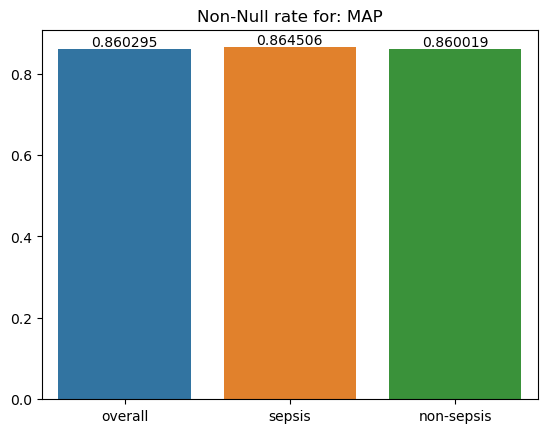

Null % CI

Mean
{'overall': 82.52983142089153, 'sepsis': 80.4415763374852, 'non-sepsis': 82.66397261092104}


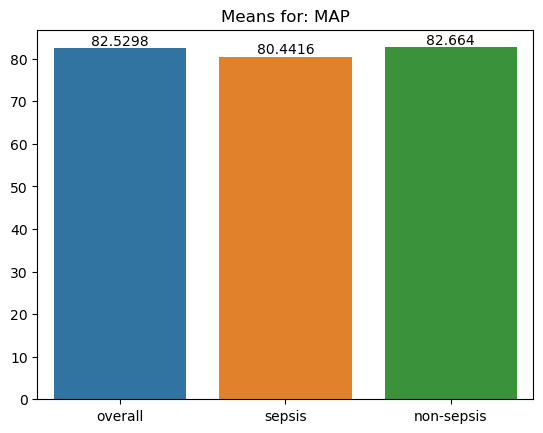

Mean % CI
{'lower bound': -4.376168396436575, 'upper bound': -0.20742498448067087, 'distance from zero': 0.20742498448067087, 'size': 4.168743411955904}
Variance
{'overall': 113.61506250688052, 'sepsis': 122.8070963004401, 'non-sepsis': 113.03822742286215}


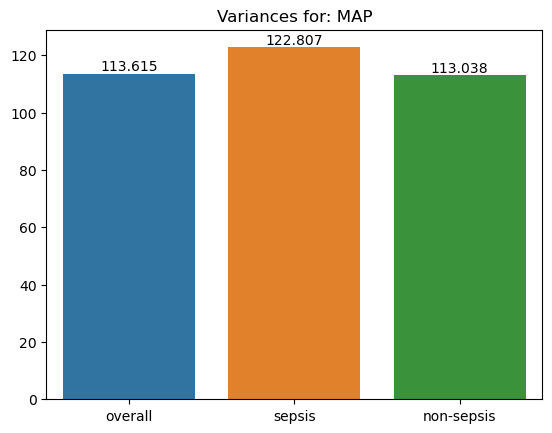

Var % CI



In [31]:
check_feature = 'MAP'
try:
    print("Not Null")
    print(null_percentages[check_feature])
    null_temp_df = pd.DataFrame.from_dict(null_percentages[check_feature], orient='index').reset_index()
    ax = sns.barplot(data=null_temp_df, x='index', y=0)
    for i in ax.containers:
        ax.bar_label(i,)
    plt.title("Non-Null rate for: " + check_feature)
    plt.xlabel("")
    plt.ylabel("")    
    plt.show()
except:
    print()
try:
    print("Null % CI")
    print(null_CI[check_feature])
except:
    print()
try:
    print("Mean")
    print(means[check_feature])
    mean_temp_df = pd.DataFrame.from_dict(means[check_feature], orient='index').reset_index()
    ax = sns.barplot(data=mean_temp_df, x='index', y=0)
    for i in ax.containers:
        ax.bar_label(i,)
    plt.title('Means for: ' + check_feature)
    plt.xlabel("")
    plt.ylabel("")
    plt.show()
except:
    print()
try:
    print("Mean % CI")
    print(mean_CI[check_feature])
except:
    print()
try:
    print("Variance")
    print(vars[check_feature])
    var_temp_df = pd.DataFrame.from_dict(vars[check_feature], orient='index').reset_index()
    ax = sns.barplot(data=var_temp_df, x='index', y=0)
    for i in ax.containers:
        ax.bar_label(i,)
    plt.title("Variances for: " + check_feature)
    plt.xlabel("")
    plt.ylabel("")
    plt.show()
except:
    print()
try:
    print("Var % CI")
    print(var_CI[check_feature])
except:
    print()

We will examine Hospital Admin time, which shows how long between between entry to the ICU until hospitalization in the general wing of the hospital.

There is evidence that there is a difference in the hospital admission times and that the sepsis admission time is smaller. This makes sense because sepsis often develops in ill patients who are likely to already be in the hospital.

In [11]:
build_CI(sepsis_df['HospAdmTime'],  non_sepsis_df['HospAdmTime'], 300, 200)

Confidence Interval: (-51.10724083333334, -2.8854366666666773)


(-51.10724083333334, -2.8854366666666773)

We will check age and age by gender (the literature indicates that women get sepsis at an older age). We find that there is no (bootstrap) evidence for a difference between the two populations by age.

In [8]:
print("General CI")
build_CI(sepsis_df['age'],  non_sepsis_df['age'], 300, 100)
print("CI for men")
build_CI(sepsis_df[sepsis_df['gender'] == 1]['age'],  non_sepsis_df[non_sepsis_df['gender'] == 1]['age'], 300, 100)
print("CI for women")
build_CI(sepsis_df[sepsis_df['gender'] == 0]['age'],  non_sepsis_df[non_sepsis_df['gender'] == 0]['age'], 300, 100)

General CI
Confidence Interval: (-2.1400574999999993, 2.9457266666666673)
CI for men
Confidence Interval: (-2.2663025000000045, 2.4235466666666556)
CI for women
Confidence Interval: (-1.1226091666666593, 4.148594999999987)


(-1.1226091666666593, 4.148594999999987)

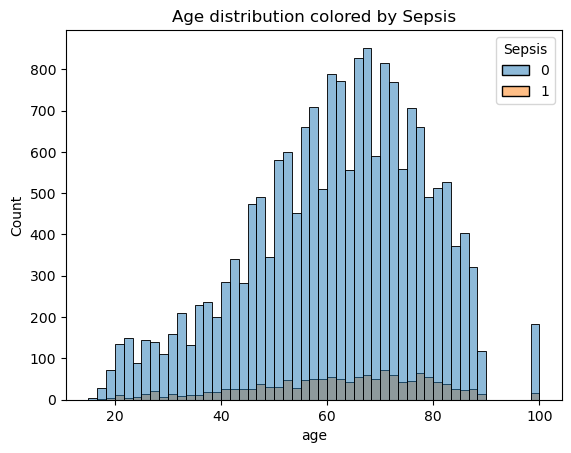

In [40]:
sns.histplot(data=all_df, x='age', hue='Sepsis')
plt.title('Age distribution colored by Sepsis')
plt.show()

We will examine the anamolys group of members aged 100. We suspect that perhaps the patients aged 100 are more sick and were specially flown in to these hospitals. But we did not find evidence that they are more sick (using the proxy of LOS)

In [18]:
build_CI(all_df[all_df['age'] > 90]['Final ICULOS'], all_df[all_df['age'] < 90]['Final ICULOS'], 300, 200)

Confidence Interval: (-3.362666666666666, 3.0995000000000017)


(-3.362666666666666, 3.0995000000000017)

We will examine the LOS that can be taken in our task (the last LOS for non-sepsis patients and 6 hours before the LOS with Sepsis).

There is evidence that their is a siginificant difference between them. This makes sense because sepsis patients spend much of their time in the ICU with Sepsis based on the data.

In [12]:
build_CI(sepsis_df['Sepsis ICULOS'], non_sepsis_df['Final ICULOS'], 300, 200)

Confidence Interval: (6.396583333333336, 19.461833333333335)


(6.396583333333336, 19.461833333333335)

In [33]:
last_LOS_for_model = pd.concat([all_df[all_df['Sepsis'] == 1][['Sepsis', 'Sepsis ICULOS']].rename(columns={'Sepsis ICULOS': 'Final ICULOS'}), all_df[all_df['Sepsis'] == 0][['Sepsis', 'Final ICULOS']]])
last_LOS_for_model.head()

,Sepsis,Final ICULOS
14421,1,54.0
17558,1,3.0
1873,1,1.0
14108,1,13.0
6739,1,69.0


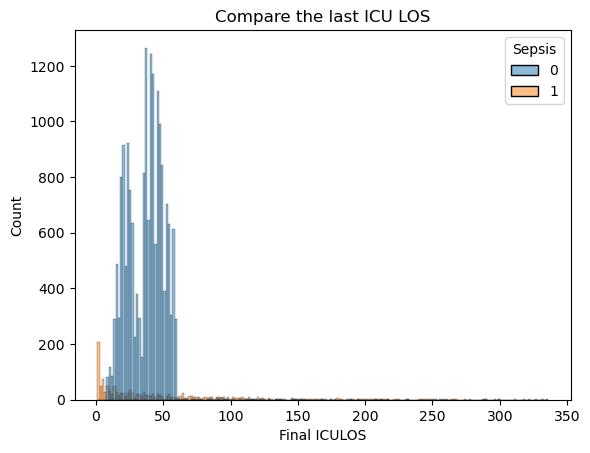

In [35]:
sns.histplot(data=last_LOS_for_model, x='Final ICULOS', hue='Sepsis')
plt.title('Compare the last ICU LOS')
plt.show()

We will now use Hypothesis testing to check our expectations from the discrete categories for which we can use a standard chi squared test.
We will test gender and unit.

We find that gender is correlated to Sepsis at a p-value of around 0.5. 
This makes sense because based on the literature men are more succeptible to sepsis and we find that to be the case here. However, we will note that would we adjust for multiple comparisons, this would not be considered statistically significant (even by less conservative adjustments then Bernoulli).
Nevertheless, based on the literature we will still use this feature. 

In [20]:
gender_data = [[((all_df.gender == 1) & (all_df.Sepsis == 1)).sum(), ((all_df.gender == 1) & (all_df.Sepsis == 0)).sum()], 
               [((all_df.gender == 0) & (all_df.Sepsis == 1)).sum(), ((all_df.gender == 0) & (all_df.Sepsis == 0)).sum()]]
print(gender_data)
stat, p, dof, expected = chi2_contingency(gender_data)
print(p)
print(f'{((all_df.gender == 1) & (all_df.Sepsis == 1)).sum()/(all_df.gender == 1).sum()} % of men (n={(all_df.gender == 1).sum()}) with sepsis vs. {((all_df.gender == 0) & (all_df.Sepsis == 1)).sum()/(all_df.gender == 0).sum()}% women (n={(all_df.gender == 0).sum()}) with sepsis in data')


[[822, 10288], [593, 8297]]
0.04902474059626093
0.07398739873987399 % of men (n=11110) with sepsis vs. 0.06670416197975253% women (n=8890) with sepsis in data


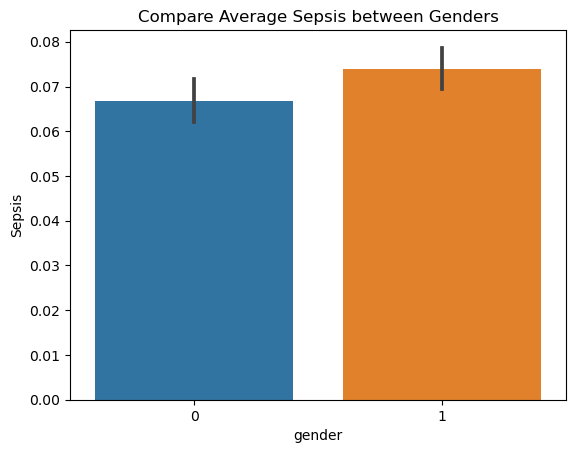

In [36]:
sns.barplot(data=all_df, y='Sepsis', x='gender')
plt.title('Compare Average Sepsis between Genders')
plt.show()

We look at which unit the patients were treated and find that at a very significant level unit is correlated to sepsis. Likely, even if we would control for multiple testing on all of the tests that we performed here this would be statistically significant.
It is likely that unit 1 treats more ill patients. However, we will note that this information is often lacking and therefore the statistic could be biased.

In [138]:
unit_data = [[((all_df.unit == 1) & (all_df.Sepsis == 1)).sum(), ((all_df.unit == 1) & (all_df.Sepsis == 0)).sum()], 
               [((all_df.unit == 2) & (all_df.Sepsis == 1)).sum(), ((all_df.unit == 2) & (all_df.Sepsis == 0)).sum()]]
stat, p, dof, expected = chi2_contingency(unit_data)
print(p)
print(f'{((all_df.unit == 1) & (all_df.Sepsis == 1)).sum()/(all_df.unit == 1).sum()} % of unit1 (n={(all_df.unit == 1).sum()}) with sepsis vs. {((all_df.unit == 2) & (all_df.Sepsis == 1)).sum()/(all_df.unit == 2).sum()}% unit2 (n={(all_df.unit == 2).sum()}) with sepsis in data')


7.212712069706973e-09
0.07602435412209972 % of unit1 (n=6077) with sepsis vs. 0.050505050505050504% unit2 (n=6237) with sepsis in data


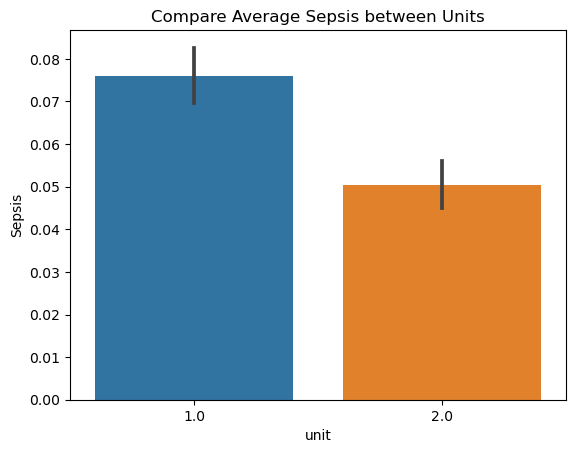

In [39]:
sns.barplot(data=all_df, y='Sepsis', x='unit')
plt.title('Compare Average Sepsis between Units')
plt.show()